In [ ]:
import pandas as pd

test_path = '/content/test_set_AB.csv'
train_path = '/content/train_set_AB.csv'

test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

In [ ]:
print(len(test_df.columns))

27


In [ ]:
print(test_df.shape)
# print(test_df.columns)
print(train_df.shape)
# print(train_df.columns)

# unmon label = 95
mon = train_df[train_df['label'] != 95]
unmon = train_df[train_df['label'] == 95]

print(f"Monitored samples: {len(mon)}, Unmonitored samples: {len(unmon)}")

(8700, 27)
(20300, 27)
Monitored samples: 13300, Unmonitored samples: 7000


### Closed-world

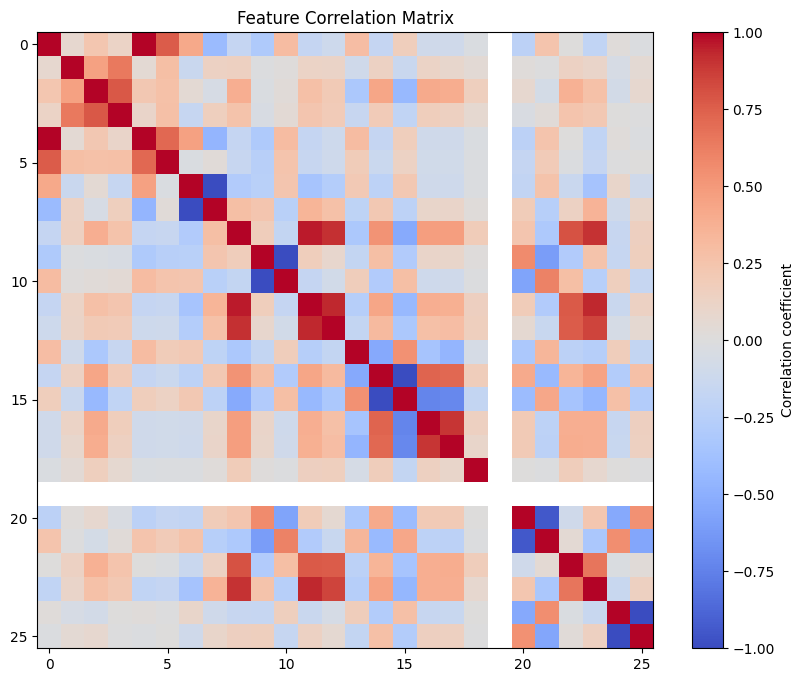

Highly correlated feature pairs (|r| > 0.9):
in_ratio_total      out_ratio_total         1.000000
in_ratio_N_pkts     out_ratio_N_pkts        1.000000
out_ratio_T_sec     in_ratio_T_sec          1.000000
num_in              total_packets           0.998001
time_for_N_pkts     avg_ipt_N_pkts          0.955675
burst_count_N_pkts  avg_burst_len_N_pkts    0.941114
std_ipt_N_pkts      avg_ipt_N_pkts          0.935657
avg_ipt_N_pkts      avg_ipt_in_N_pkts       0.932788
std_ipt_N_pkts      time_for_N_pkts         0.909169
time_for_N_pkts     avg_ipt_in_N_pkts       0.902926
dtype: float64
Recommended features to drop due to high correlation:
['avg_burst_len_N_pkts', 'avg_ipt_N_pkts', 'in_ratio_T_sec', 'out_ratio_N_pkts', 'out_ratio_total', 'time_for_N_pkts', 'total_packets']
7 개


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

corr = mon.drop(columns=['label'], errors='ignore').corr()  # label 제외

# plot
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("Feature Correlation Matrix")
plt.colorbar(label='Correlation coefficient')
plt.show()

# highly correlated 쌍 찾기
threshold = 0.9
corr_pairs = (
    corr.abs()
    .unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)
high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > threshold)]

print("Highly correlated feature pairs (|r| > 0.9):")
print(high_corr)

to_drop = set()
for f1, f2 in high_corr.index:
    if f1 not in to_drop:
        to_drop.add(f2)

print("Recommended features to drop due to high correlation:")
print(sorted(to_drop))
print(len(to_drop), '개')

In [ ]:
keep_features = mon.drop(columns=['avg_burst_len_N_pkts', 'avg_ipt_N_pkts', 'in_ratio_T_sec',
                                  'out_ratio_N_pkts', 'out_ratio_total', 'time_for_N_pkts', 'total_packets', 'label'], errors='ignore').columns.tolist()
print(len(keep_features), keep_features)

19 ['t_max', 't_mean', 't_std', 'num_in', 'num_out', 'in_ratio_total', 'in_ratio_N_pkts', 'std_ipt_N_pkts', 'packets_in_T_sec', 'out_ratio_T_sec', 'avg_ipt_T_sec', 'std_ipt_T_sec', 'time_to_first_in', 'pkts_before_first_in', 'burst_count_N_pkts', 'avg_ipt_out_N_pkts', 'avg_ipt_in_N_pkts', 'in_ratio_N_pkts_30', 'out_ratio_N_pkts_30']


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# 현재 monitored_all 에서 실제 존재하는 피처만 사용
keep_features_in_use = [f for f in keep_features if f in mon.columns]
missing = sorted(set(keep_features) - set(keep_features_in_use))
if missing:
    print("[Info] Missing features (auto-dropped):", missing)
print("[Info] keep_features used:", keep_features_in_use)


# 데이터 준비
#   A: Closed-world train/test, 전체 feature 사용한 버전
#   B: monitored_all에서 stratified sample로 A의 train 크기와 동일하게 (75%) 뽑고 keep_features만 사용
assert 'label' in train_df.columns and 'label' in test_df.columns, "label 컬럼 필요"

X_train_full = train_df.drop(columns=['label'])
y_train_full = train_df['label'].astype(int)

X_test_full  = test_df.drop(columns=['label'])
y_test       = test_df['label'].astype(int)  # 공통 target

X_train_selected = train_df[keep_features]
y_train_selected = train_df['label'].astype(int)

X_test_selected = test_df[keep_features]
y_test_selected = test_df['label'].astype(int)

print(f"[Shape] A (full) train: {X_train_full.shape}, test: {X_test_full.shape}")
print(f"[Shape] B (selected) train: {X_train_selected.shape}, test: {X_test_selected.shape}")
print(f"[Check] Train size matched? {len(X_train_full) == len(X_train_selected)}")


# XGBoost
num_class = y_train_full.nunique()
xgb_params = dict(
    objective='multi:softmax',
    num_class=num_class,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=42,
    eval_metric='mlogloss'
)

# NN
mlp_params = dict(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    alpha=1e-4,                # L2 reg
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42,
    verbose=False
)

model_full_xgb = XGBClassifier(**xgb_params)
model_selected_xgb = XGBClassifier(**xgb_params)

model_full_mlp = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('mlp', MLPClassifier(**mlp_params))
    ])
model_selected_mlp = Pipeline([
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('mlp', MLPClassifier(**mlp_params))
    ])

model_full_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=3.0, kernel='rbf', gamma='scale', probability=True, random_state=42))
])
model_selected_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=3.0, kernel='rbf', gamma='scale', probability=True, random_state=42))
])

# 학습
print("\n[Train] XGBoost (Full features) ...")
model_full_xgb.fit(X_train_full, y_train_full)

print("[Train] XGBoost (Selected features) ...")
model_selected_xgb.fit(X_train_selected, y_train_selected)

print("\n[Train] MLP (Full features) ...")
model_full_mlp.fit(X_train_full, y_train_full)

print("\n[Train] MLP (Selected features) ...")
model_selected_mlp.fit(X_train_selected, y_train_selected)

print("\n[Train] SVM (Full features) ...")
model_full_svc.fit(X_train_full, y_train_full)

print("\n[Train] SVM (Selected features) ...")
model_selected_svc.fit(X_train_selected, y_train_selected)


def safe_logloss(y_true, proba):
    try:
        return log_loss(y_true, proba, labels=np.unique(y_true))
    except Exception:
        return np.nan

# 결과 및 비교

# XGB (full)
y_pred_full_xgb = model_full_xgb.predict(X_test_full)
acc_full_xgb = accuracy_score(y_test, y_pred_full_xgb)
# 확률 필요 시
y_proba_full_xgb = model_full_xgb.predict_proba(X_test_full)
ll_full_xgb = safe_logloss(y_test, y_proba_full_xgb)

# XGB (selected)
y_pred_selected_xgb = model_selected_xgb.predict(X_test_selected)
acc_selected_xgb = accuracy_score(y_test_selected, y_pred_selected_xgb)
y_proba_selected_xgb = model_selected_xgb.predict_proba(X_test_selected)
ll_selected_xgb = safe_logloss(y_test_selected, y_proba_selected_xgb)

# MLP (full)
y_pred_full_mlp = model_full_mlp.predict(X_test_full)
acc_full_mlp = accuracy_score(y_test, y_pred_full_mlp)
y_proba_full_mlp = model_full_mlp.predict_proba(X_test_full)
ll_full_mlp = safe_logloss(y_test, y_proba_full_mlp)

# MLP (selected)
y_pred_selected_mlp = model_selected_mlp.predict(X_test_selected)
acc_selected_mlp = accuracy_score(y_test_selected, y_pred_selected_mlp)
y_proba_selected_mlp = model_selected_mlp.predict_proba(X_test_selected)
ll_selected_mlp = safe_logloss(y_test_selected, y_proba_selected_mlp)

# SVM (full)
y_pred_full_svm = model_full_svc.predict(X_test_full)
acc_full_svm = accuracy_score(y_test, y_pred_full_svm)
y_proba_full_svm = model_full_svc.predict_proba(X_test_full)
ll_full_svm = safe_logloss(y_test, y_proba_full_svm)

# SVM (selected)
y_pred_selected_svm = model_selected_svc.predict(X_test_selected)
acc_selected_svm = accuracy_score(y_test_selected, y_pred_selected_svm)
y_proba_selected_svm = model_selected_svc.predict_proba(X_test_selected)
ll_selected_svm = safe_logloss(y_test_selected, y_proba_selected_svm)

print("\n==== Accuracy / LogLoss Comparison (Closed-world) ====")
print(f"[XGB]  Full      -> Acc: {acc_full_xgb:.4f}     | LogLoss: {ll_full_xgb:.4f}")
print(f"[XGB]  Selected  -> Acc: {acc_selected_xgb:.4f} | LogLoss: {ll_selected_xgb:.4f}")
print(f"[MLP]  Full      -> Acc: {acc_full_mlp:.4f}     | LogLoss: {ll_full_mlp:.4f}")
print(f"[MLP]  Selected  -> Acc: {acc_selected_mlp:.4f} | LogLoss: {ll_selected_mlp:.4f}")
print(f"[SVM]  Full      -> Acc: {acc_full_svm:.4f}     | LogLoss: {ll_full_svm:.4f}")
print(f"[SVM]  Selected  -> Acc: {acc_selected_svm:.4f} | LogLoss: {ll_selected_svm:.4f}")

[Info] keep_features used: ['t_max', 't_mean', 't_std', 'num_in', 'num_out', 'in_ratio_total', 'in_ratio_N_pkts', 'std_ipt_N_pkts', 'packets_in_T_sec', 'out_ratio_T_sec', 'avg_ipt_T_sec', 'std_ipt_T_sec', 'time_to_first_in', 'pkts_before_first_in', 'burst_count_N_pkts', 'avg_ipt_out_N_pkts', 'avg_ipt_in_N_pkts', 'in_ratio_N_pkts_30', 'out_ratio_N_pkts_30']
[Shape] A (full) train: (20300, 26), test: (8700, 26)
[Shape] B (selected) train: (20300, 19), test: (8700, 19)
[Check] Train size matched? True

[Train] XGBoost (Full features) ...
[Train] XGBoost (Selected features) ...

[Train] MLP (Full features) ...

[Train] MLP (Selected features) ...

[Train] SVM (Full features) ...

[Train] SVM (Selected features) ...

==== Accuracy / LogLoss Comparison (Closed-world) ====
[XGB]  Full      -> Acc: 0.8076     | LogLoss: 0.7472
[XGB]  Selected  -> Acc: 0.8010 | LogLoss: 0.7687
[MLP]  Full      -> Acc: 0.6967     | LogLoss: 1.3185
[MLP]  Selected  -> Acc: 0.6954 | LogLoss: 1.2722
[SVM]  Full    


=== Multi-class Metrics (macro) ===
                           ROC_AUC  MACRO_F1  ACCURACY
XGBoost (Full)              0.9924    0.7702    0.8076
XGBoost (Selected)          0.9920    0.7603    0.8010
Neural Network (Full)       0.9806    0.6206    0.6967
Neural Network (Selected)   0.9815    0.6190    0.6954
SVM (Full)                  0.9741    0.4474    0.5840
SVM (Selected)              0.9723    0.4377    0.5799


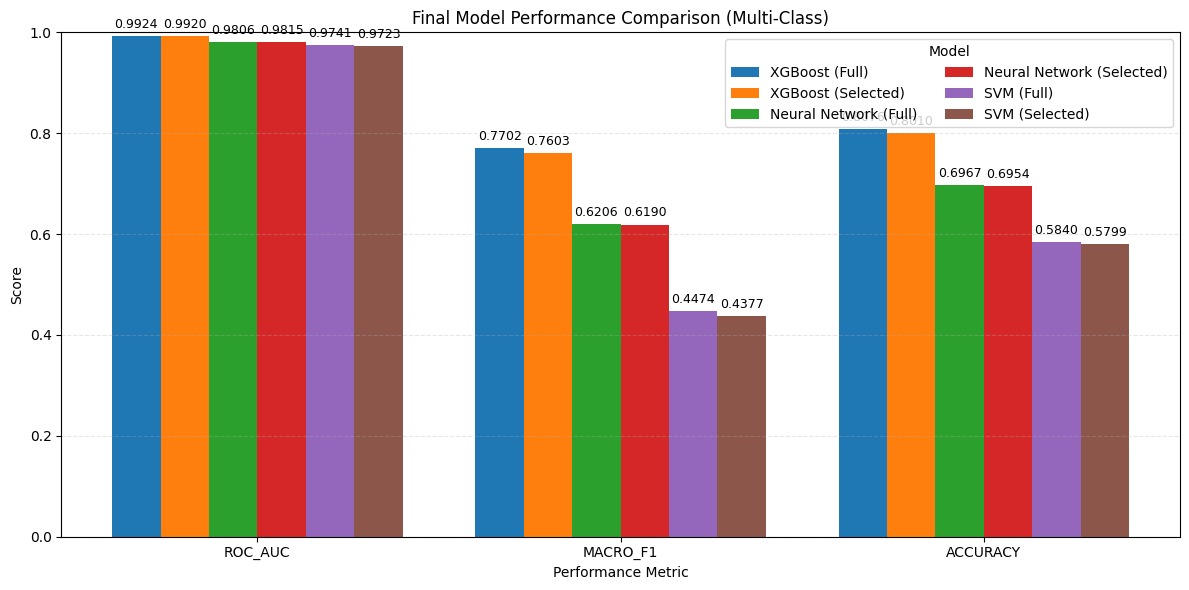

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def compute_multiclass_metrics(y_true, y_pred, proba_or_score, labels=None):
    """
    y_true: shape (n,)
    y_pred: shape (n,)
    proba_or_score: shape (n, n_classes)  # predict_proba or decision_function
    labels: optional explicit label set (sorted int labels recommended)
    """
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    # ROC-AUC(ovr, macro) — need per-class scores/probabilities
    try:
        roc_auc = roc_auc_score(
            y_true,
            proba_or_score,
            multi_class='ovr',
            average='macro',
            labels=labels
        )
    except Exception:
        roc_auc = np.nan

    return {"ROC_AUC": roc_auc, "MACRO_F1": macro_f1, "ACCURACY": acc}


class_labels = np.unique(y_test)  # 멀티클래스 라벨 집합

runs = []

# XGBoost (Full)
runs.append((
    "XGBoost (Full)",
    compute_multiclass_metrics(
        y_test, y_pred_full_xgb, y_proba_full_xgb, labels=class_labels
    )
))

# XGBoost (Keep)
runs.append((
    "XGBoost (Selected)",
    compute_multiclass_metrics(
        y_test_selected, y_pred_selected_xgb, y_proba_selected_xgb, labels=class_labels
    )
))

# MLP (Full)
runs.append((
    "Neural Network (Full)",
    compute_multiclass_metrics(
        y_test, y_pred_full_mlp, y_proba_full_mlp, labels=class_labels
    )
))

# MLP (Keep)
runs.append((
    "Neural Network (Selected)",
    compute_multiclass_metrics(
        y_test_selected, y_pred_selected_mlp, y_proba_selected_mlp, labels=class_labels
    )
))

# SVM (Full)
runs.append((
    "SVM (Full)",
    compute_multiclass_metrics(
        y_test, y_pred_full_svm, y_proba_full_svm, labels=class_labels
    )
))

# SVM (Selected)
runs.append((
    "SVM (Selected)",
    compute_multiclass_metrics(
        y_test_selected, y_pred_selected_svm, y_proba_selected_svm, labels=class_labels
    )
))

# ===== 표 형태로 출력 =====
import pandas as pd
metrics_df = pd.DataFrame(
    {name: m for name, m in runs}
).T[["ROC_AUC", "MACRO_F1", "ACCURACY"]]
print("\n=== Multi-class Metrics (macro) ===")
print(metrics_df.round(4))


# ===== 막대 그래프 =====
metrics_order = ["ROC_AUC", "MACRO_F1", "ACCURACY"]
model_names = [name for name, _ in runs]
scores_by_metric = {metric: [runs[i][1][metric] for i in range(len(runs))]
                    for metric in metrics_order}

x = np.arange(len(metrics_order))
width = 0.8 / len(model_names)  # metric당 막대들을 나란히 배치

fig, ax = plt.subplots(figsize=(12, 6))
for i, model in enumerate(model_names):
    offsets = x - 0.4 + width/2 + i*width
    vals = [scores_by_metric[m][i] for m in metrics_order]
    rects = ax.bar(offsets, vals, width, label=model)
    # 값 라벨
    for r in rects:
        h = r.get_height()
        ax.text(r.get_x() + r.get_width()/2.0, h + 0.01, f"{h:.4f}", ha='center', va='bottom', fontsize=9)

ax.set_title("Final Model Performance Comparison (Multi-Class)")
ax.set_xlabel("Performance Metric")
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(metrics_order)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend(title="Model", ncol=2)
plt.tight_layout()
plt.show()

### Open-world (multiclass)

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu, ks_2samp

# Feature 분포 비교
results = []
mon = train_df

for col in mon.columns:
    # 결측값 제거
    x = mon[col].dropna()
    y = unmon[col].dropna()
    if x.nunique() < 5 or y.nunique() < 5:
        continue  # 값이 너무 단조로우면 skip

    # 두 가지 검정 병행
    ks_stat, ks_p = ks_2samp(x, y)
    mw_stat, mw_p = mannwhitneyu(x, y, alternative='two-sided')

    results.append({
        'feature': col,
        'ks_stat': ks_stat,
        'ks_p': ks_p,
        'mw_stat': mw_stat,
        'mw_p': mw_p
    })

df_diff = pd.DataFrame(results)

# 유의하게 다른 feature 추출
n1, n2 = len(mon), len(unmon)
mw_upper = 0.95 * n1 * n2
mw_lower = 0.05 * n1 * n2

# KS + MW 극단
sig_features = df_diff[
    ((df_diff['ks_p'] < 0.05) | (df_diff['mw_p'] < 0.05)) &
    ((df_diff['ks_p'] < 0.05) | (df_diff['mw_p'] < 0.05)) &
    (df_diff['ks_stat'] > 0.2)
].sort_values(by='ks_stat', ascending=False)

print(f"\nmon과 unmon에서 다르게 분포하는 feature: {len(sig_features)}개")
print(sig_features[['feature', 'ks_stat', 'ks_p', 'mw_stat', 'mw_p']])


mon과 unmon에서 다르게 분포하는 feature: 2개
                feature   ks_stat           ks_p     mw_stat           mw_p
23   in_ratio_N_pkts_30  0.214054  8.628764e-210  88946860.0  9.436677e-224
24  out_ratio_N_pkts_30  0.214054  8.628764e-210  53153140.0  9.436677e-224


In [ ]:
print(train_df.columns)

Index(['total_packets', 't_max', 't_mean', 't_std', 'num_in', 'num_out',
       'in_ratio_total', 'out_ratio_total', 'time_for_N_pkts',
       'out_ratio_N_pkts', 'in_ratio_N_pkts', 'avg_ipt_N_pkts',
       'std_ipt_N_pkts', 'packets_in_T_sec', 'out_ratio_T_sec',
       'in_ratio_T_sec', 'avg_ipt_T_sec', 'std_ipt_T_sec', 'time_to_first_in',
       'pkts_before_first_in', 'burst_count_N_pkts', 'avg_burst_len_N_pkts',
       'avg_ipt_out_N_pkts', 'avg_ipt_in_N_pkts', 'in_ratio_N_pkts_30',
       'out_ratio_N_pkts_30', 'label'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight

assert 'label' in train_df.columns, "'label' 없음"
assert 'label' in test_df.columns, "'label' 없음"

scaler = QuantileTransformer(output_distribution='normal', random_state=42)
X_train = train_df.drop(columns=['label'])
X_train = scaler.fit_transform(X_train) # outlier 영향 줄임
y_train = train_df['label'].astype(int)

X_test = test_df.drop(columns=['label'])
X_test = scaler.transform(X_test)
y_test = test_df['label'].astype(int)

num_class = y_train.nunique()
print(f"[Info] 총 클래스 수: {num_class}")

sw = compute_sample_weight(class_weight='balanced', y=y_train)

# XGBoost
xgb_params = dict(
    objective='multi:softmax',
    num_class=num_class,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=42,
    eval_metric='mlogloss'
)

model_xgb = XGBClassifier(**xgb_params)
print("\n[Train] XGBoost ...")
model_xgb.fit(X_train, y_train, sample_weight=sw)

# NN
mlp_params = dict(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=3e-4,
    batch_size=512,
    learning_rate_init=1e-3,
    max_iter=120,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42,
    verbose=True
)

from imblearn.over_sampling import RandomOverSampler  # MLP는 sample_weight 지원 X

ros = RandomOverSampler(random_state=42)
X_train_mlp, y_train_mlp = ros.fit_resample(X_train, y_train)

model_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(**mlp_params))
])

print("\n[Train] MLP ...")
model_mlp.fit(X_train_mlp, y_train_mlp)

svm_96 = Pipeline([
    ('scaler', RobustScaler()),
    ('svc', SVC(C=3.0, kernel='rbf', gamma='scale', class_weight='balanced', probability=True, random_state=42))
])

print("\n[Train] SVM (96-class) ...")
svm_96.fit(X_train, y_train)

# eval
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # predict_proba가 있으면 ROC-AUC 계산
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    try:
        if y_proba is not None:
            auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
        else:
            auc = np.nan
    except Exception:
        auc = np.nan

    print(f"\n[{model_name}] Results:")
    print(f"  Accuracy : {acc:.4f}")
    return acc, f1, auc

# 결과

acc_xgb, f1_xgb, auc_xgb = evaluate_model(model_xgb, X_test, y_test, "XGBoost")
acc_mlp, f1_mlp, auc_mlp = evaluate_model(model_mlp, X_test, y_test, "MLP")
acc_svm96, f1_svm96, auc_svm96 = evaluate_model(svm_96, X_test, y_test, "SVM (96-class)")

[Info] 총 클래스 수: 96

[Train] XGBoost ...

[Train] MLP ...
Iteration 1, loss = 2.12008160
Validation score: 0.613289
Iteration 2, loss = 1.26420059
Validation score: 0.702202
Iteration 3, loss = 1.00923265
Validation score: 0.748259
Iteration 4, loss = 0.85721220
Validation score: 0.778899
Iteration 5, loss = 0.75205091
Validation score: 0.803125
Iteration 6, loss = 0.67059327
Validation score: 0.826339
Iteration 7, loss = 0.60628244
Validation score: 0.834777
Iteration 8, loss = 0.55327317
Validation score: 0.853943
Iteration 9, loss = 0.50704473
Validation score: 0.857128
Iteration 10, loss = 0.46634973
Validation score: 0.877009
Iteration 11, loss = 0.43157184
Validation score: 0.884807
Iteration 12, loss = 0.40092105
Validation score: 0.895074
Iteration 13, loss = 0.37213715
Validation score: 0.902500
Iteration 14, loss = 0.34609092
Validation score: 0.909539
Iteration 15, loss = 0.32342152
Validation score: 0.915685
Iteration 16, loss = 0.30127363
Validation score: 0.928318
Iteratio

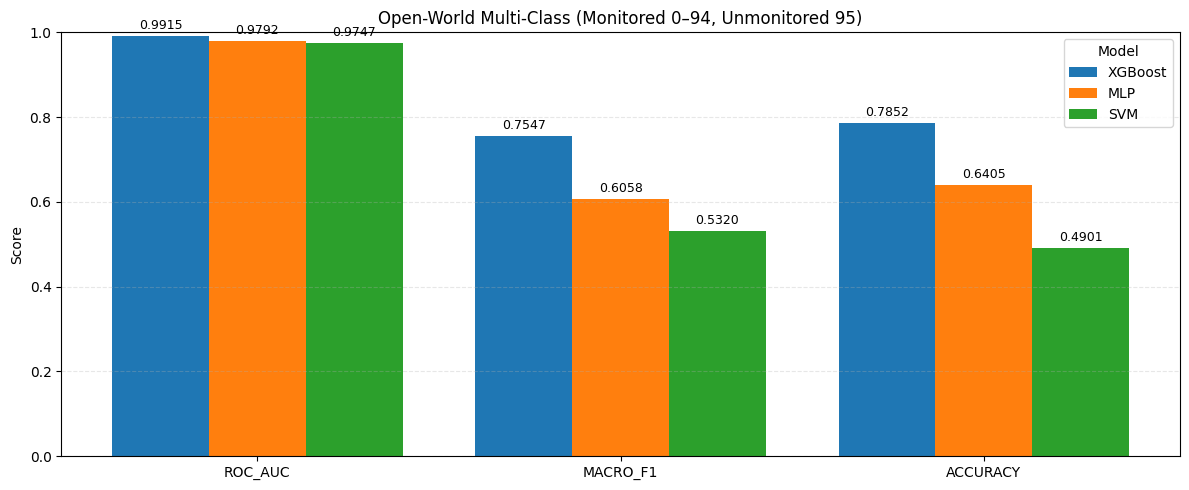

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# === 각 모델 점수 (이미 계산해둔 변수 사용) ===
metrics = ['ROC_AUC', 'MACRO_F1', 'ACCURACY']
scores_xgb = [auc_xgb, f1_xgb, acc_xgb]
scores_mlp = [auc_mlp, f1_mlp, acc_mlp]
scores_svm = [auc_svm96, f1_svm96, acc_svm96]

# === 막대 폭/좌표 설정 (3개 모델) ===
x = np.arange(len(metrics))
n_models = 3
width = 0.8 / n_models   # metric당 전체 폭 0.8을 3등분

fig, ax = plt.subplots(figsize=(12, 5))

# 각 모델 오프셋
offsets = [-width, 0.0, width]

rects1 = ax.bar(x + offsets[0], scores_xgb, width, label='XGBoost')
rects2 = ax.bar(x + offsets[1], scores_mlp, width, label='MLP')
rects3 = ax.bar(x + offsets[2], scores_svm, width, label='SVM')

# 값 라벨 표시
for rects in [rects1, rects2, rects3]:
    for r in rects:
        h = r.get_height()
        ax.text(r.get_x() + r.get_width()/2, h + 0.01, f"{h:.4f}",
                ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Score')
ax.set_title('Open-World Multi-Class (Monitored 0–94, Unmonitored 95)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.0)
ax.legend(title='Model')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()